In [1]:
cpu_count = 100
import os
os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={cpu_count}'
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random, jit, vmap

In [2]:
import dmeq

In [3]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
import arviz as az

In [4]:
n_chains = 10

In [5]:
# install cudnn from tar and not dpkg
key = random.PRNGKey(42)

In [6]:
def full_solution(params, eir, eta):
    p = dmeq.default_parameters()
    for k, v in params.items():
        p[k] = v
    p['EIR'] = eir
    p['eta'] = eta
    return dmeq.solve(p, dtype=jnp.float64)

In [7]:
population = 1_000_000
prev_N = 1_000

def prev_stats(params, eir, eta, impl=full_solution):
    solution = impl(params, eir, eta)
    inc_rates = solution[1] * solution[-1] * population
    return (
        jnp.array([
            solution[0, 3:10].sum() / solution[-1, 3:10].sum(), # Prev 2 - 10
            solution[0, 10:].sum() / solution[-1, 10:].sum(), # Prev 10+
        ]),
        jnp.array([
            inc_rates[:5].sum(), # Inc 0 - 5
            inc_rates[5:15].sum(), # Inc 5 - 15
            inc_rates[15:].sum() # Inc 15+
        ])
    )

In [8]:
prev_stats_multisite = vmap(prev_stats, in_axes=[None, 0, 0, None])

In [9]:
EIRs = jnp.array([0.05, 3.9, 15., 20., 100., 150., 418.])
key, key_i = random.split(key)
etas = 1. / random.uniform(key_i, shape=EIRs.shape, minval=20*365, maxval=40*365, dtype=jnp.float64)

In [10]:
def model(prev=None, inc=None, impl=lambda p, e, a: prev_stats_multisite(p, e, a, full_solution)):
    # Pre-erythrocytic immunity
    kb = numpyro.sample('kb', dist.LogNormal(0., .25))
    ub = numpyro.sample('ub', dist.LogNormal(0., .25))
    b0 = numpyro.sample('b0', dist.Beta(1., 1.))
    IB0 = numpyro.sample('IB0', dist.LeftTruncatedDistribution(dist.Normal(50., 10.), low=0.))
    
    # Clinical immunity
    kc = numpyro.sample('kc', dist.LogNormal(0., .25))
    uc = numpyro.sample('uc', dist.LogNormal(0., .25))
    phi0 = numpyro.sample('phi0', dist.Beta(5., 1.))
    phi1 = numpyro.sample('phi1', dist.Beta(1., 2.))
    IC0 = numpyro.sample('IC0', dist.LeftTruncatedDistribution(dist.Cauchy(100., 10.), low=0.))
    PM = numpyro.sample('PM', dist.Beta(1., 1.))
    dm = numpyro.sample('dm', dist.LeftTruncatedDistribution(dist.Cauchy(200., 10.), low=0.))
    
    # Detection immunity
    kd = numpyro.sample('kd', dist.LogNormal(0., .25))
    ud = numpyro.sample('ud', dist.LogNormal(0., .25))
    d1 = numpyro.sample('d1', dist.Beta(1., 2.))
    ID0 = numpyro.sample('ID0', dist.LeftTruncatedDistribution(dist.Cauchy(25., 1.), low=0.))
    fd0 = numpyro.sample('fd0', dist.Beta(1., 1.))
    gd = numpyro.sample('gd', dist.LogNormal(0., .25))
    ad0 = numpyro.sample('ad0', dist.TruncatedDistribution(
        dist.Cauchy(30. * 365., 365.),
        low=20. * 365.,
        high=40. * 365.
    ))
    
    du = numpyro.sample('du', dist.LeftTruncatedDistribution(dist.Cauchy(50., 1.), low=0.))
    
    # FOIM
    cd = numpyro.sample('cd', dist.Beta(1., 2.))
    cu = numpyro.sample('cu', dist.Beta(1., 5.))
    g_inf = numpyro.sample('g_inf', dist.Gamma(3., 1.))
    
    prev_stats, inc_stats = impl({
        'kb': kb,
        'ub': ub,
        'b0': b0,
        'IB0': IB0,
        'kc': kc,
        'uc': uc,
        'IC0': IC0,
        'phi0': phi0,
        'phi1': phi1,
        'PM': PM,
        'dm': dm,
        'kd': kd,
        'ud': ud,
        'd1': d1,
        'ID0': ID0,
        'fd0': fd0,
        'gd': gd,
        'ad0': ad0,
        'rU': 1. / du,
        'cd': cd,
        'cu': cu,
        'g_inf': g_inf
    }, EIRs, etas)
    numpyro.sample(
        'obs_prev',
        dist.Independent(
            dist.Binomial(total_count=prev_N, probs=prev_stats, validate_args=True),
            1
        ),
        obs=prev
    )
    numpyro.sample(
        'obs_inc',
        dist.Independent(
            dist.Poisson(rate=inc_stats),
            1
        ),
        obs=inc
    )

In [11]:
key, key_i = random.split(key)
true_values = Predictive(model, num_samples=1)(key_i)

In [12]:
true_values

{'IB0': Array([58.7365734], dtype=float64),
 'IC0': Array([103.92720686], dtype=float64),
 'ID0': Array([25.62619726], dtype=float64),
 'PM': Array([0.72981111], dtype=float64),
 'ad0': Array([10555.96766056], dtype=float64),
 'b0': Array([0.74543618], dtype=float64),
 'cd': Array([0.22820082], dtype=float64),
 'cu': Array([0.11498384], dtype=float64),
 'd1': Array([0.61861621], dtype=float64),
 'dm': Array([182.8618928], dtype=float64),
 'du': Array([61.98810811], dtype=float64),
 'fd0': Array([0.95786433], dtype=float64),
 'g_inf': Array([0.87178758], dtype=float64),
 'gd': Array([1.60818405], dtype=float64),
 'kb': Array([0.73792907], dtype=float64),
 'kc': Array([1.25727826], dtype=float64),
 'kd': Array([1.64091344], dtype=float64),
 'obs_inc': Array([[[  0,   0,   0],
         [ 10,  30,  26],
         [ 35,  59,  57],
         [ 34,  53,  84],
         [ 81, 116, 197],
         [146, 190, 192],
         [191, 251, 383]]], dtype=int64),
 'obs_prev': Array([[[  5,  10],
         [

In [13]:
obs_inc, obs_prev = (true_values['obs_inc'], true_values['obs_prev'])

In [14]:
key, key_i = random.split(key)
prior = Predictive(model, num_samples=600)(key)

In [15]:
def without_obs(params):
    return {k : v for k, v in params.items() if not k in {'obs_inc', 'obs_prev'}}

In [16]:
from jax import pmap, tree_map
import jax
import pandas as pd
from scipy.stats.qmc import LatinHypercube

train_samples = int(1e5)
device_count = len(jax.devices())

In [17]:
# Create the X_prior dataset

def pmap_prior(k):
    return Predictive(model, num_samples=train_samples // cpu_count)(k)

key, *keys = random.split(key, num=cpu_count + 1)
train_prior = pmap(pmap_prior, in_axes=0, devices=jax.devices('cpu'))(jnp.stack(keys))
train_prior = jax.tree_map(lambda x: jnp.reshape(x, (train_samples, -1)), train_prior)
X_prior, x_def = jax.tree_util.tree_flatten(without_obs(train_prior))
X_prior = jnp.concatenate(X_prior, axis=1)

In [18]:
# Create the X_lhs dataset
bounds = pd.DataFrame.from_records([
    ('kb', 0.01, 10),
    ('ub', 1, 10),
    ('b0', .01, .99),
    ('IB0', 1, 100),
    ('kc', .01, 10),
    ('uc', 1, 10),
    ('IC0', 1, 100),
    ('phi0', 0, 1),
    ('phi1', 0, 1),
    ('PM', 0, 1),
    ('dm', 0, 1000),
    ('kd', .01, 10),
    ('ud', 1, 10),
    ('d1', 0, 1),
    ('ID0', 1, 100),
    ('fd0', 0, 1),
    ('gd', 1, 10),
    ('ad0', 20 * 365, 40 * 365),
    ('du', 30, 1000),
    ('cd', 0, 1),
    ('cu', 0, 1),
    ('g_inf', 0.01, 10)
], columns=['name', 'lower', 'upper'])

sampler = LatinHypercube(d=len(bounds), seed=42)
samples = sampler.random(train_samples)
ordered_bounds = bounds.set_index('name').loc[pd.Series(without_obs(train_prior).keys())]

X_lhs = samples * (
    ordered_bounds.upper - ordered_bounds.lower
).to_numpy() + ordered_bounds.lower.to_numpy()

In [19]:
# Sample site parameters

bounds = pd.DataFrame.from_records([
    ('EIR', 0., 500.),
    ('eta', 1/(40 * 365), 1/(20 * 365))
], columns=['name', 'lower', 'upper'])
sampler = LatinHypercube(d=len(bounds), seed=42)
X_site = sampler.random(train_samples)
X_site = X_site * (bounds.upper - bounds.lower).to_numpy() + bounds.lower.to_numpy()

In [20]:
# Sample full y
def sample_full_y(x, x_site):
    params = jax.tree_util.tree_unflatten(x_def, x)
    return full_solution(params, x_site[0], x_site[1])

def sample_y_from_x(x, x_site, impl):
    y = pmap(vmap(impl), devices=jax.devices('cpu'))(
        jnp.reshape(x, (cpu_count, x.shape[0] // cpu_count,) + x.shape[1:]),
        jnp.reshape(x_site, (cpu_count, x_site.shape[0] // cpu_count,) + x_site.shape[1:])
    )
    y_shape = y.shape[2:]
    return (jnp.reshape(y, (train_samples,) + y_shape), y_shape)

y_prior_full, y_shape = sample_y_from_x(X_prior, X_site, sample_full_y)
y_lhs_full, y_shape = sample_y_from_x(X_lhs, X_site, sample_full_y)

# sample fixed y
def sample_fixed_y(x, x_site):
    params = jax.tree_util.tree_unflatten(x_def, x)
    return jnp.concatenate(prev_stats_multisite(params, EIRs, etas, full_solution), axis=1)

y_prior_fixed , y_shape_fixed = sample_y_from_x(X_lhs, X_site, sample_fixed_y)
y_lhs_fixed , y_shape_fixed = sample_y_from_x(X_lhs, X_site, sample_fixed_y)

In [21]:
def split(x, split):
    return (x[:split], x[split:])

val_split = int(.8 * train_samples)

def standardise(x, mean, std):
    return (x - mean) / std

def inverse_standardise(x, mean, std):
    return x * std + mean

def adapt(x, x_val, axis):
    mean, std = jnp.mean(x, axis=axis, keepdims=True), jnp.std(x, axis=axis, keepdims=True)
    return (standardise(x, mean, std), standardise(x_val, mean, std), mean, std)

datasets = {
    'X_prior': (X_prior, 0),
    'X_lhs': (X_lhs, 0),
    'X_site': (X_site, 0),
    'y_prior_full': (y_prior_full, (0, 2)),
    'y_lhs_full': (y_lhs_full, (0, 2)),
    # 'y_prior_full': (y_prior_full, 0),
    # 'y_lhs_full': (y_lhs_full, 0),
    'y_prior_fixed': (y_prior_fixed, 0),
    'y_lhs_fixed': (y_lhs_fixed, 0)
}

def process_dataset(x, axis):
    x, x_val = split(x, val_split)
    return adapt(x, x_val, axis)

datasets = { k: process_dataset(*v) for k, v in datasets.items()}

In [22]:
from flax import linen as nn
from jax.nn import softplus
import optax
from jax import value_and_grad
from jaxtyping import Array

In [23]:
def maskedminmaxrelu(x, min_x, max_x, idx):
    '''relu with a min and max, however max_x is only set at idx'''
    filtered_min = jnp.maximum(x, min_x)
    filtered_max = jnp.minimum(filtered_min, max_x)
    return filtered_min.at[idx].set(filtered_max[idx])

class MaskedMinMaxSurrogate(nn.Module):
    units: int
    n_hidden: int
    n_output: int
    y_min: Array
    y_max: Array
    idx_max: Array

    @nn.compact
    def __call__(self, x):
        layers = [nn.Dense(self.units) for _ in range(self.n_hidden)]
        for i, lyr in enumerate(layers):
            x = lyr(x)
            x = nn.relu(x)
        x = nn.Dense(self.n_output)(x)
        return maskedminmaxrelu(x, self.y_min, self.y_max, self.idx_max)

def l2_loss(x, alpha):
    return alpha * (x ** 2).mean()

def log_cosh(model, params, x_batched, y_batched):
    # Define a numerically stable log cosh for a single pair (x,y)
    def error(x, y):
        pred = model.apply(params, x)
        diff = y - pred
        return jnp.mean(diff + softplus(-2 * diff) - jnp.log(2.))

    # Regularisation loss
    reg_loss = sum(
        l2_loss(w, alpha=0.001)
        for w in jax.tree_util.tree_leaves(params)
    )

    # Vectorize the previous to compute the average of the loss on all samples.
    return jnp.mean(vmap(error)(x_batched, y_batched), axis=0) + reg_loss

In [24]:
def make_surrogate(key, X, X_val, y, y_shape, idx_max):
    y, y_val, y_mean, y_std = y
    surrogate_model = MaskedMinMaxSurrogate(
        units=288,
        n_hidden=3,
        n_output=jnp.product(jnp.array(y_shape)),
        y_min=standardise(jnp.zeros(y_shape), y_mean, y_std)[0].reshape(-1),
        y_max=standardise(jnp.ones(y_shape), y_mean, y_std)[0].reshape(-1),
        idx_max=idx_max
    )
    surrogate_params = surrogate_model.init(key, X)

    tx = optax.adam(learning_rate=.001)
    opt_state = tx.init(surrogate_params)
    loss_grad_fn = value_and_grad(jit(lambda p, x, y: log_cosh(surrogate_model, p, x, y)))

    batch_size = 100

    n_batches = X.shape[0] // batch_size
    X_batched = jnp.reshape(X, (n_batches, batch_size, -1))
    y_batched = jnp.reshape(y, (n_batches, batch_size, -1))

    epochs = 100
    
    for i in range(epochs):
        key, key_i = random.split(key)
        
        for b in random.permutation(key_i, n_batches, independent=True):
            loss_val, grads = loss_grad_fn(
                surrogate_params,
                X_batched[b],
                y_batched[b]
            )
            updates, opt_state = tx.update(grads, opt_state)
            surrogate_params = optax.apply_updates(surrogate_params, updates)

    return (surrogate_model, surrogate_params)

In [25]:
def make_full_surrogate(key, x, x_site, y):
    x, x_val = x[:2]
    x_site, x_site_val = x_site[:2]

    X = jnp.concatenate([x_site, x], axis=1)
    X_val = jnp.concatenate([x_site_val, x_val], axis=1)
    idx_max = jnp.arange(jnp.product(jnp.array(y_shape)))
    return make_surrogate(
        key,
        X,
        X_val,
        y,
        y_shape,
        idx_max
    )

def make_fixed_surrogate(key, x, y):
    x, x_val = x[:2]
    idx_max = jnp.arange(jnp.product(jnp.array(y_shape_fixed)))
    idx_max = jnp.reshape(idx_max.reshape(y_shape_fixed)[:,:2], -1)
    return make_surrogate(
        key,
        x,
        x_val,
        y,
        y_shape_fixed,
        idx_max
    )

In [30]:
n_sample_points = 10

def subsample(d, sample_size):
    return {k: tuple([a[:sample_size] for a in v]) for k, v in datasets.items()}

def surrogates_for_sample_size(key_i, sample_size):
    print('sample_size:', sample_size)
    d = subsample(datasets, sample_size)
    
    return {
        'prior_full': make_full_surrogate(
            key_i[0],
            d['X_prior'],
            d['X_site'],
            d['y_prior_full']
        ),
        'lhs_full': make_full_surrogate(
            key_i[1],
            d['X_lhs'],
            d['X_site'],
            d['y_lhs_full']
        ),
        'prior_fixed': make_fixed_surrogate(
            key_i[2],
            d['X_prior'],
            d['y_prior_fixed']
        ),
        'lhs_fixed': make_fixed_surrogate(
            key_i[3],
            d['X_lhs'],
            d['y_lhs_fixed']
        )
    }

In [26]:
lhs_fixed_surrogate = make_fixed_surrogate(
    key,
    datasets['X_lhs'],
    datasets['y_lhs_fixed']
)

In [31]:
key, *key_i = random.split(key, num=4*n_sample_points + 1)
sample_points = jnp.linspace(1000, train_samples, num=n_sample_points, dtype=jnp.int64)
surrogates = [
    surrogates_for_sample_size(keys, sample_size)
    for keys, sample_size in
    list(zip(
        jnp.reshape(jnp.stack(key_i), (len(sample_points), 4, -1)),
        sample_points
    ))
]

sample_size: 1000
sample_size: 12000
sample_size: 23000
sample_size: 34000
sample_size: 45000
sample_size: 56000
sample_size: 67000
sample_size: 78000
sample_size: 89000
sample_size: 100000


In [30]:
sample_map = {k: 0 for k in without_obs(prior).keys()}

def full_solution_surrogate(model, params, model_params, x, x_site, y, eir, eta):
    X_site_mean, X_site_std = x_site[2:]
    X_mean, X_std = x[2:]
    y_mean, y_std = y[2:]
    p = jnp.concatenate([
        jnp.array([eir, eta]),
        jax.flatten_util.ravel_pytree(model_params)[0]
    ])
    mean = jnp.concatenate([X_site_mean, X_mean], axis=1)
    std = jnp.concatenate([X_site_std, X_std], axis=1)
    y = model.apply(params, standardise(p, mean, std)[0])
    return inverse_standardise(
        jnp.reshape(y, y_shape),
        y_mean,
        y_std
    )[0]

pred_y_full = vmap(
    lambda x, f: jnp.concatenate(prev_stats_multisite(x, EIRs, etas, f), axis=1),
    [sample_map, None]
)

def fixed_solution_surrogate(model, params, model_params, x, y):
    X_mean, X_std = x[2:]
    y_mean, y_std = y[2:]
    p = jax.flatten_util.ravel_pytree(model_params)[0]
    y = model.apply(params, standardise(p, X_mean, X_std)[0])
    return inverse_standardise(
        jnp.reshape(y, y_shape_fixed),
        y_mean,
        y_std
    )[0]

pred_y_fixed = vmap(fixed_solution_surrogate, [None, None, sample_map, None, None])

In [33]:
# calculate the loss in prev/incidence
y = pred_y_full(without_obs(prior), full_solution)

In [34]:
y_hat_prior_full = [pred_y_full(
    without_obs(prior),
    lambda p, e, a: full_solution_surrogate(
        *s['prior_full'],
        p,
        datasets['X_prior'],
        datasets['X_site'],
        datasets['y_prior_full'],
        e,
        a,
    )
) for s in surrogates]

y_hat_lhs_full = [pred_y_full(
    without_obs(prior),
    lambda p, e, a: full_solution_surrogate(
        *s['lhs_full'],
        p,
        datasets['X_lhs'],
        datasets['X_site'],
        datasets['y_lhs_full'],
        e,
        a,
    )
) for s in surrogates]

In [35]:
y_hat_prior_fixed = [pred_y_fixed(
    *s['prior_fixed'],
    without_obs(prior),
    datasets['X_prior'],
    datasets['y_prior_fixed']
) for s in surrogates]

y_hat_lhs_fixed = [pred_y_fixed(
    *s['lhs_fixed'],
    without_obs(prior),
    datasets['X_lhs'],
    datasets['y_lhs_fixed']
) for s in surrogates]

In [36]:
import pandas as pd
import seaborn as sns
y_labels = ['prev2-10', 'prev10+', 'inc0-5', 'inc5-15', 'inc15+']

In [37]:
y_hats = {
    'prior_full': y_hat_prior_full,
    'lhs_full': y_hat_lhs_full,
    'prior_fixed': y_hat_prior_fixed,
    'lhs_fixed': y_hat_lhs_fixed
}

In [38]:
df = pd.concat([
    pd.DataFrame({
        'samples': sample_points[u],
        'RE': jnp.abs(y - y_hat[u])[:, i, j] / y[:, i, j],
        'EIR': EIRs[i],
        'output': y_labels[j],
        'surrogate': s_label
    })
    for i in range(len(EIRs))
    for j in range(len(y_labels))
    for s_label, y_hat in y_hats.items()
    for u in range(len(sample_points))
])

In [39]:
df.EIR = df.EIR.astype(int)

In [40]:
df.samples = df.samples.astype(int)

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/gc1610/projects/eqio/env/lib/python3.10/site-p

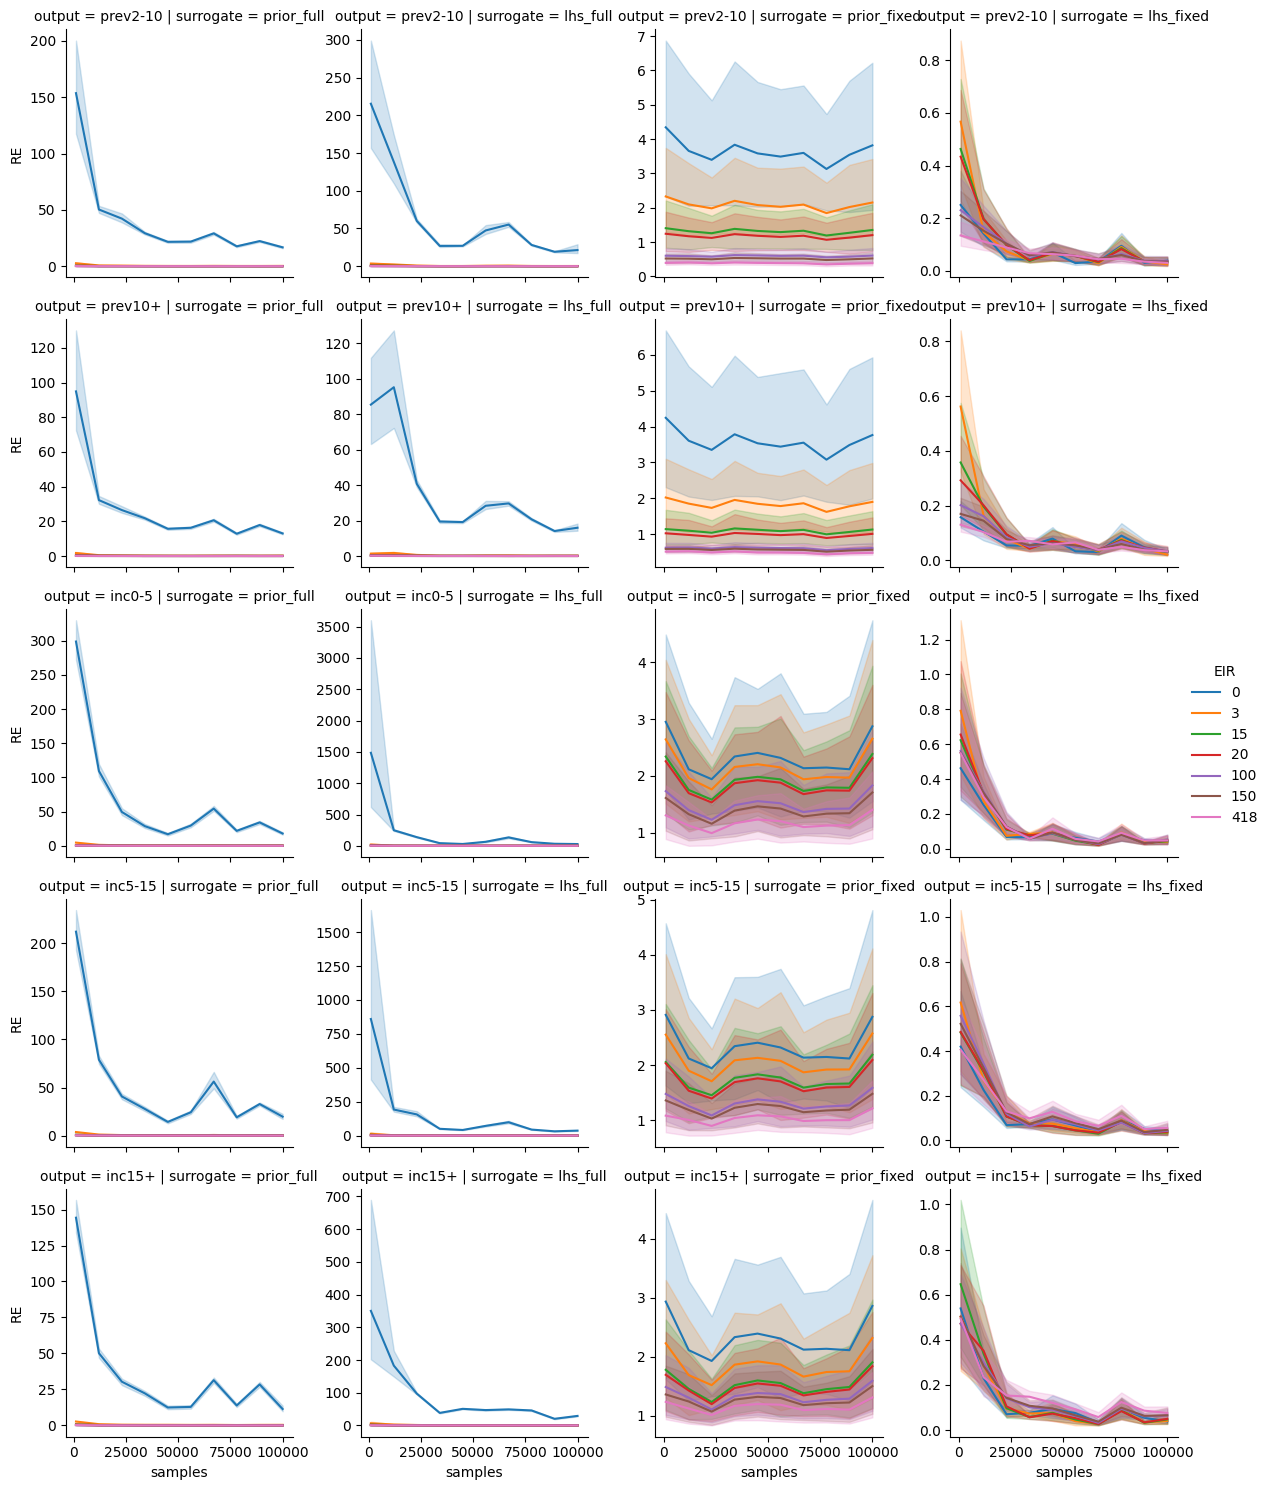

In [41]:
g = sns.FacetGrid(df, row="output", col='surrogate', hue='EIR', sharey=False)
g.map(sns.lineplot, "samples", "RE")
g.add_legend()

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/seaborn/axis

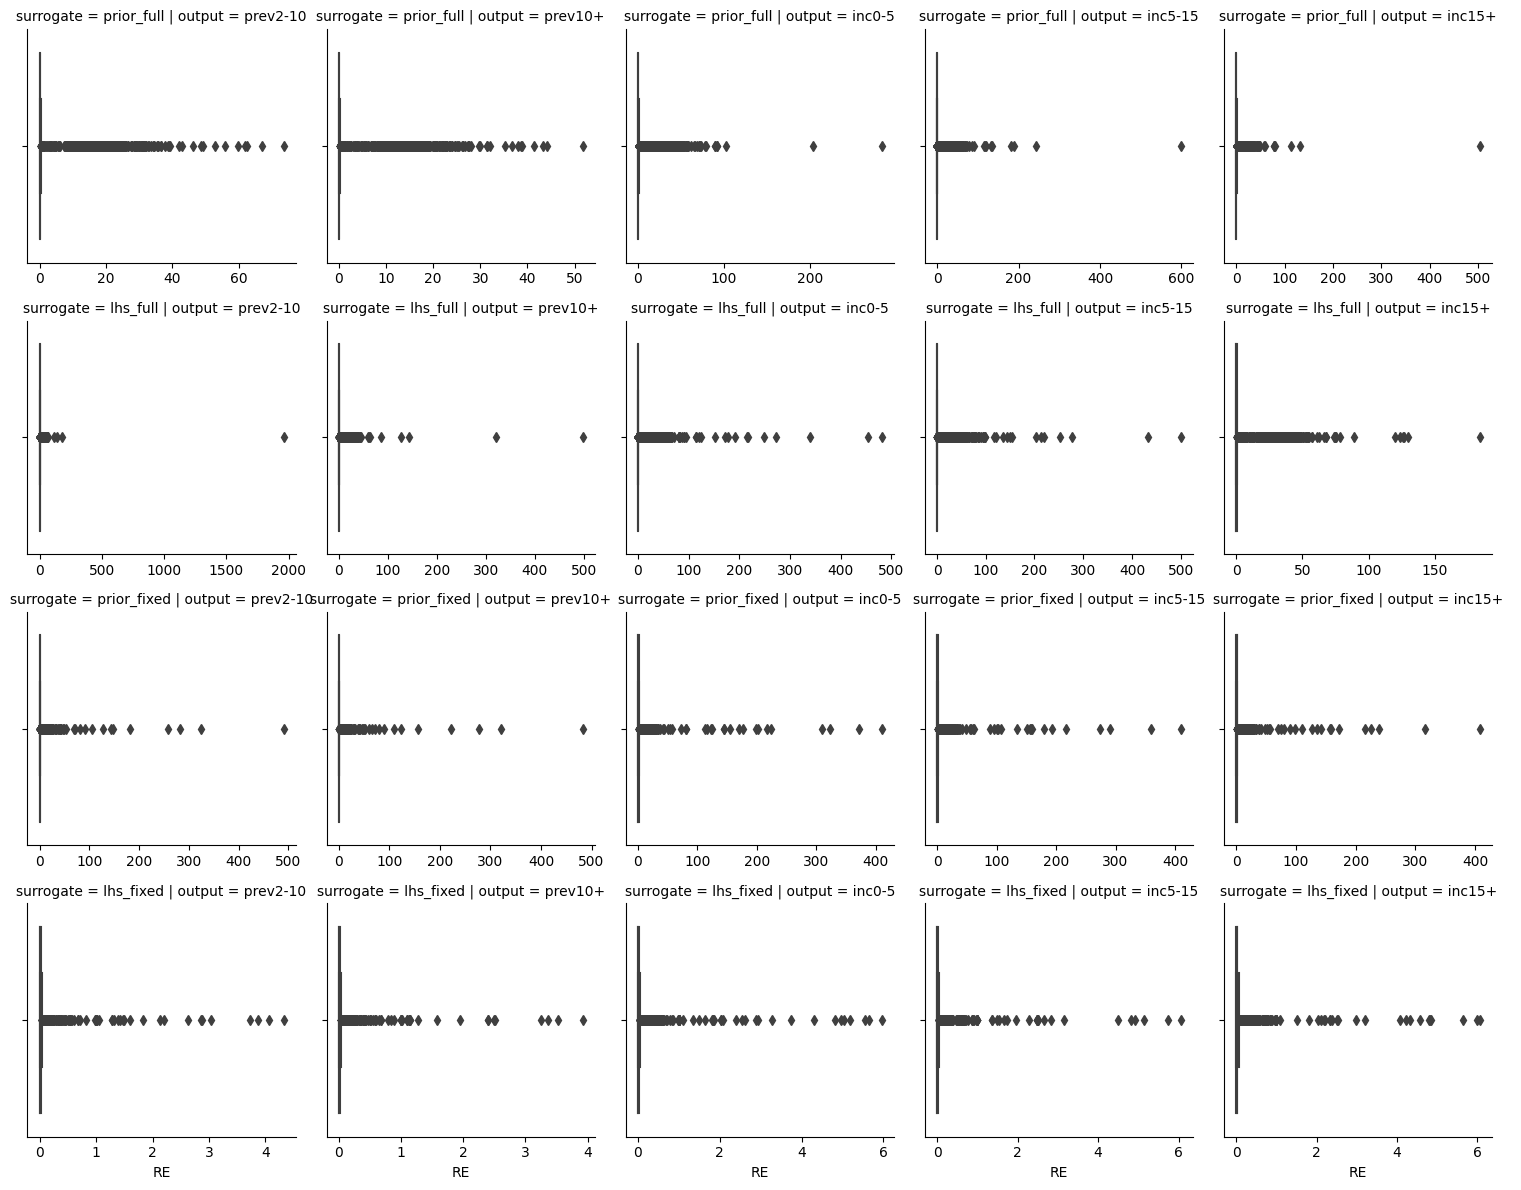

In [42]:
g = sns.FacetGrid(df[df.samples == sample_points[-1]], col='output', row='surrogate', sharex=False)
g.map(sns.boxplot, "RE")
g.add_legend()

In [43]:
df[(df.samples == sample_points[-1]) & (df.EIR == 0)].groupby(
    ['EIR', 'output', 'surrogate'], as_index=False
).agg({'RE': ['mean', 'std']}).sort_values(('RE', 'mean'))

EIR    output    surrogate         RE           
                                    mean        std
12   0   prev10+    lhs_fixed   0.030947   0.094298
16   0  prev2-10    lhs_fixed   0.038469   0.117505
4    0    inc15+    lhs_fixed   0.038480   0.147386
0    0    inc0-5    lhs_fixed   0.039270   0.151588
8    0   inc5-15    lhs_fixed   0.041548   0.174152
6    0    inc15+  prior_fixed   2.864349  20.274485
2    0    inc0-5  prior_fixed   2.872564  20.352238
10   0   inc5-15  prior_fixed   2.873465  20.351981
14   0   prev10+  prior_fixed   3.762863  26.797557
18   0  prev2-10  prior_fixed   3.817293  27.196705
7    0    inc15+   prior_full  11.450644  24.306819
15   0   prev10+   prior_full  13.018224   6.724143
13   0   prev10+     lhs_full  15.967648  25.516719
19   0  prev2-10   prior_full  16.717171   9.551854
3    0    inc0-5   prior_full  17.995451  22.694440
11   0   inc5-15   prior_full  19.749529  33.228217
17   0  prev2-10     lhs_full  21.356358  80.312128
1    0    inc0-5     lhs_full  28.022922  41.563067
5    0    inc15+     lhs_full  29.169481  18.513198
9    0   inc5-15     lhs_full  36.938482  37.528095

In [44]:
def plot_surrogate_predictive_error(y_hat):
    fig, axs = plt.subplots(5, len(EIRs), figsize=(10, 8))
    
    for i in range(5):
        axs[i, 0].set_ylabel(y_labels[i])
        for j in range(len(EIRs)):
            axs[0, j].set_xlabel(
                f'EIR: {EIRs[j]}'
            )
            axs[0, j].xaxis.set_label_position('top')
            axs[i, j].plot(
                y[:,j, i],
                y_hat[:,j,i],
                linestyle='',
                marker='o',
                markersize=0.7
            )
            lim = min(axs[i,j].get_ylim()[1], axs[i,j].get_xlim()[1])
            guide = jnp.linspace(0, lim)
            axs[i, j].plot(guide, guide, c='r')

    fig.tight_layout()

    fig.text(0.5, 0, 'Predictive error', ha='center')

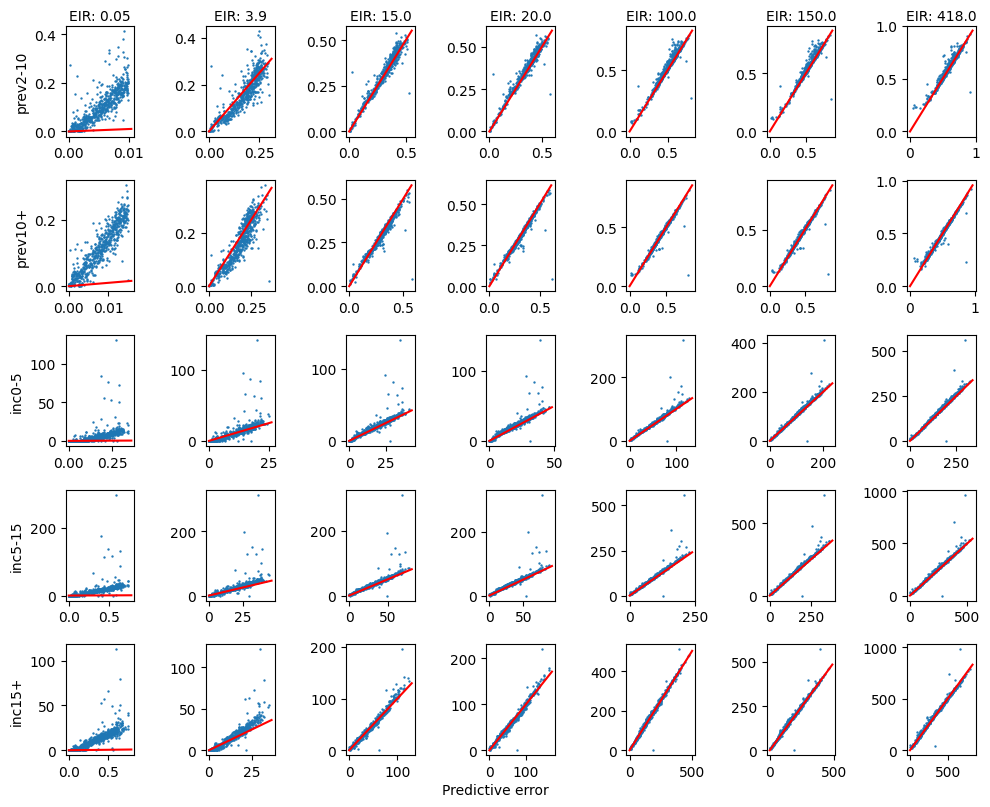

In [45]:
plot_surrogate_predictive_error(y_hat_lhs_full[-1])

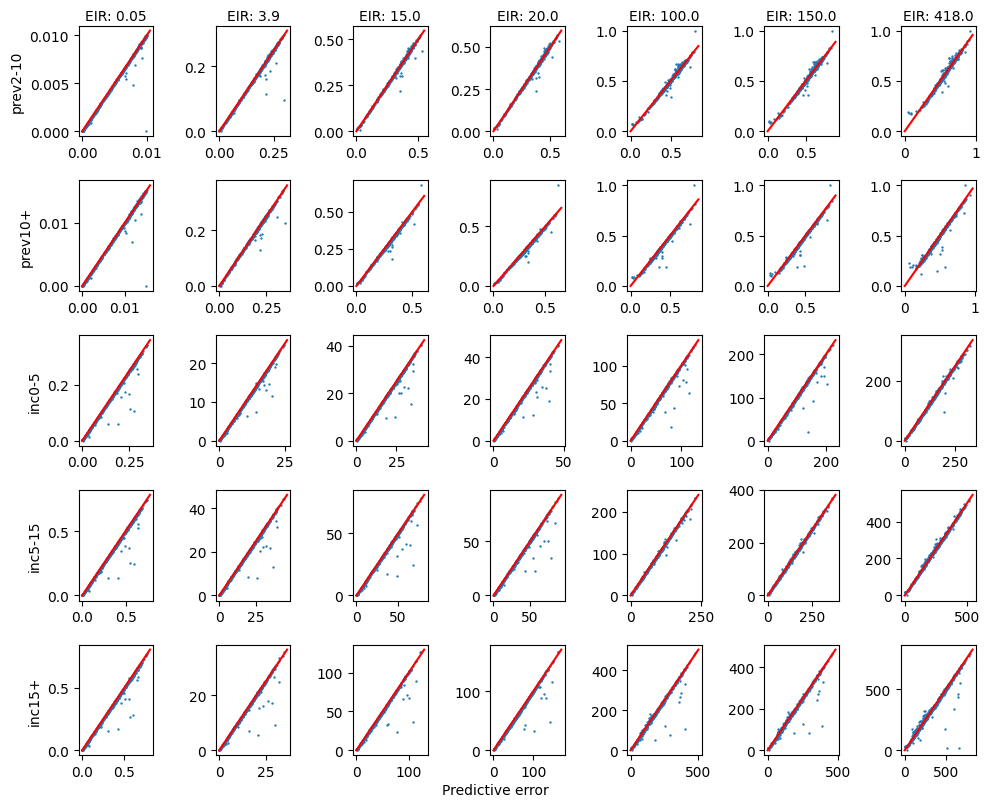

In [46]:
plot_surrogate_predictive_error(y_hat_lhs_fixed[-1])

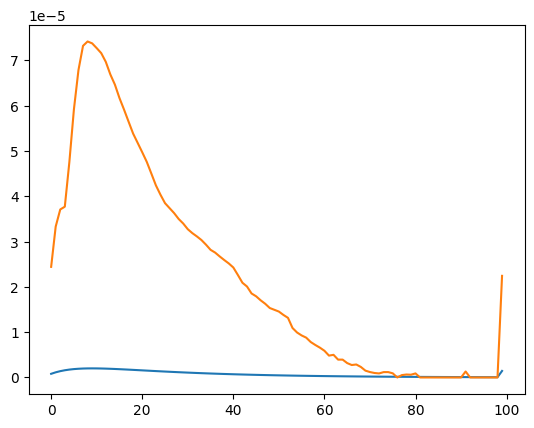

In [49]:
plt.plot(full_solution(true_values, EIRs[0], etas[0])[1])
plt.plot(full_solution_surrogate(
    *surrogates[-1]['lhs_full'],
    without_obs(true_values),
    datasets['X_lhs'],
    datasets['X_site'],
    datasets['y_lhs_full'], EIRs[0], etas[0])[1]
)

# TODO

 * ~Unnormalised prev loss (for survey stats) for easy comparison~
 * ~Is X_site included in training set??~
 * ~Why is unnormalised loss 0?~
 * ~Kernel resarting for surrogate~
 * ~Validation set in training~
 * ~Are the bounds sensible?? No, for EIR, for etas?~
 * Fix props?
 * Good posterior found with low error. However, weird convergence statistics
   * ~constraining neural network?~
   * ~regularisation~
   * fourier net?
   * The density of the true values is much lower in the surrogate!
     * high loss at low EIRs
 * Exchange replica with random walk

In [27]:
n_samples = 100
n_warmup = 100

mcmc = MCMC(
    NUTS(model),
    num_samples=n_samples,
    num_warmup=n_warmup,
    num_chains=n_chains,
    chain_method='vectorized'
)
mcmc.run(key, obs_prev, obs_inc)
mcmc.print_summary(prob=0.7)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [1:06:51<00:00, 20.06s/it]



                mean       std    median     15.0%     85.0%     n_eff     r_hat
       IB0     53.06      9.74     52.85     42.32     62.84   1189.51      1.00
       IC0    104.44     12.79    102.63     90.28    111.54    907.63      1.01
       ID0     24.75      2.24     24.88     23.30     26.13    428.62      1.02
        PM      0.50      0.29      0.50      0.26      0.94   1407.95      1.00
       ad0  11002.00    893.10  10979.82  10328.93  11521.76    264.31      1.03
        b0      0.72      0.05      0.72      0.67      0.76    639.20      1.00
        cd      0.34      0.23      0.30      0.00      0.45   1986.49      1.00
        cu      0.17      0.14      0.13      0.00      0.21   1647.39      1.00
        d1      0.58      0.03      0.59      0.56      0.61    477.79      1.00
        dm    190.18     33.90    197.59    182.13    211.76     42.41      1.26
        du     50.41      4.34     50.00     48.43     51.75    375.42      1.03
       fd0      0.80      0

In [ ]:
surrogate_impl = lambda p, e, a: prev_stats_multisite(p, e, a, full_solution)

In [33]:
def surrogate_impl(p, e, a):
    r = fixed_solution_surrogate(*lhs_fixed_surrogate, p, datasets['X_lhs'], datasets['y_lhs_fixed'])
    return r[:,:2], r[:,2:]

In [34]:
# n_samples = 1000
# n_warmup = 1000

# from numpyro.contrib.tfp.mcmc import RandomWalkMetropolis
# import tensorflow_probability as tfp

# kernel = RandomWalkMetropolis(
#     model,
#     new_state_fn=tfp.substrates.jax.mcmc.random_walk_normal_fn(scale=.04)
# )

n_samples = 100
n_warmup = 100

kernel = NUTS(model)

mcmc_surrogate = MCMC(
    kernel,
    num_samples=n_samples,
    num_warmup=n_warmup,
    num_chains=n_chains,
    chain_method='vectorized' #pmap leads to segfault for some reason (https://github.com/google/jax/issues/13858)
)
mcmc_surrogate.run(key, obs_prev, obs_inc, surrogate_impl)
mcmc_surrogate.print_summary(prob=0.7)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:31<00:00,  2.19it/s]



                mean       std    median     15.0%     85.0%     n_eff     r_hat
       IB0     53.35     11.01     52.89     39.80     62.76    155.81      1.04
       IC0    109.16     35.10    108.12     92.11    132.79      8.75      1.58
       ID0     25.36      4.21     25.06     23.73     27.00    262.45      1.04
        PM      0.48      0.28      0.48      0.18      0.85    750.62      1.01
       ad0  10876.32    914.74  10921.62  10125.45  11396.61    248.11      1.03
        b0      0.83      0.07      0.84      0.76      0.91    105.75      1.07
        cd      0.35      0.24      0.31      0.00      0.47    674.89      1.02
        cu      0.16      0.13      0.13      0.00      0.21    736.52      1.02
        d1      0.58      0.03      0.58      0.56      0.61    189.60      1.06
        dm    199.21     22.33    200.06    184.49    215.28   1012.75      1.00
        du     33.08     22.24     48.78      4.65     51.20      8.49      1.88
       fd0      0.50      0

In [61]:
from scipy.stats import ks_2samp
sample_keys = list(posterior_samples.keys())
ks_tests = pd.DataFrame([
    {'statistic': ks_2samp(posterior_samples[k], posterior_samples_surrogate[k]).statistic, 'p-value': ks_2samp(posterior_samples[k], posterior_samples_surrogate[k]).pvalue}
    for k in sample_keys
], sample_keys)

In [65]:
from numpyro.diagnostics import summary
#d = pd.DataFrame(summary(mcmc.get_samples(group_by_chain=True), prob=0.7)).transpose()
d = pd.concat([
    pd.DataFrame(summary(mcmc.get_samples(group_by_chain=True), prob=0.7)).transpose()[['mean', 'std', 'n_eff', 'r_hat']],
    pd.DataFrame(summary(mcmc_surrogate.get_samples(group_by_chain=True), prob=0.7)).transpose()[['mean', 'std', 'n_eff', 'r_hat']],
    ks_tests
], axis=1, keys=['equilibrium solution', 'surrogate', 'KS'])
d['true_value'] = pd.Series(without_obs(true_values)).apply(lambda x: x[0]).astype(float)
print(d.to_latex(float_format="{:0.2f}".format))

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} & \multicolumn{4}{l}{equilibrium solution} & \multicolumn{4}{l}{surrogate} & \multicolumn{2}{l}{KS} & true\_value \\
{} &                 mean &    std &   n\_eff & r\_hat &      mean &    std &   n\_eff & r\_hat & statistic & \multicolumn{2}{l}{p-value} \\
\midrule
IB0   &                53.06 &   9.74 & 1189.51 &  1.00 &     53.35 &  11.01 &  155.81 &  1.04 &      0.04 &    0.29 &      58.74 \\
IC0   &               104.44 &  12.79 &  907.63 &  1.01 &    109.16 &  35.10 &    8.75 &  1.58 &      0.22 &    0.00 &     103.93 \\
ID0   &                24.75 &   2.24 &  428.62 &  1.02 &     25.36 &   4.21 &  262.45 &  1.04 &      0.09 &    0.00 &      25.63 \\
PM    &                 0.50 &   0.29 & 1407.95 &  1.00 &      0.48 &   0.28 &  750.62 &  1.01 &      0.04 &    0.54 &       0.73 \\
ad0   &             11002.00 & 893.10 &  264.31 &  1.03 &  10876.32 & 914.74 &  248.11 &  1.03 &      0.06 &    0.05 &   10555.97 \\
b0    &                 0.

/tmp/ipykernel_56934/634325103.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(d.to_latex(float_format="{:0.2f}".format))


In [36]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(
    model,
    posterior_samples
)(key, obs_prev, obs_inc)

In [37]:
posterior_samples_surrogate = mcmc_surrogate.get_samples()
posterior_predictive_surrogate = Predictive(
    model,
    posterior_samples_surrogate
)(key, obs_prev, obs_inc)

In [ ]:
fig, axs = plt.subplots(3, len(EIRs), sharey=True, sharex=True)
imm_labels = ['b', 'c', 'd']
for i in range(len(EIRs)):
    axs[0, i].set_xlabel(
        f'EIR: {EIRs[i]}'
    )
    axs[0, i].xaxis.set_label_position('top')
    for imm in range(3):
        axs[imm, i].plot(posterior_curves[i, :, 2+imm, :].T, color='r', alpha=.01)
        axs[imm, i].plot(true_curves[i, 0, 2+imm, :])
        axs[imm, 0].set_ylabel(f'prob. {imm_labels[imm]}')
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Posterior immunity probability function', ha='center')

In [ ]:
fig, axs = plt.subplots(2, len(EIRs), sharey='row', sharex=True)

prev_labels = ['pos_M', 'inc']
for i in range(len(EIRs)):
    for prev in range(2):
        axs[0, i].set_xlabel(
            f'EIR: {EIRs[i]}'
        )
        axs[0, i].xaxis.set_label_position('top')
        axs[prev, i].plot(posterior_curves[i, :, prev, :].T, color='r', alpha=.01)
        axs[prev, i].plot(true_curves[i, 0, prev, :])
        axs[prev, 0].set_ylabel(prev_labels[prev])
        #axs[prev, 0].set_yscale('log')
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Posterior pos_M/inc function', ha='center')

In [40]:
pyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)
pyro_data_surrogate = az.from_numpyro(
    mcmc_surrogate,
    prior=prior,
    posterior_predictive=posterior_predictive_surrogate
)

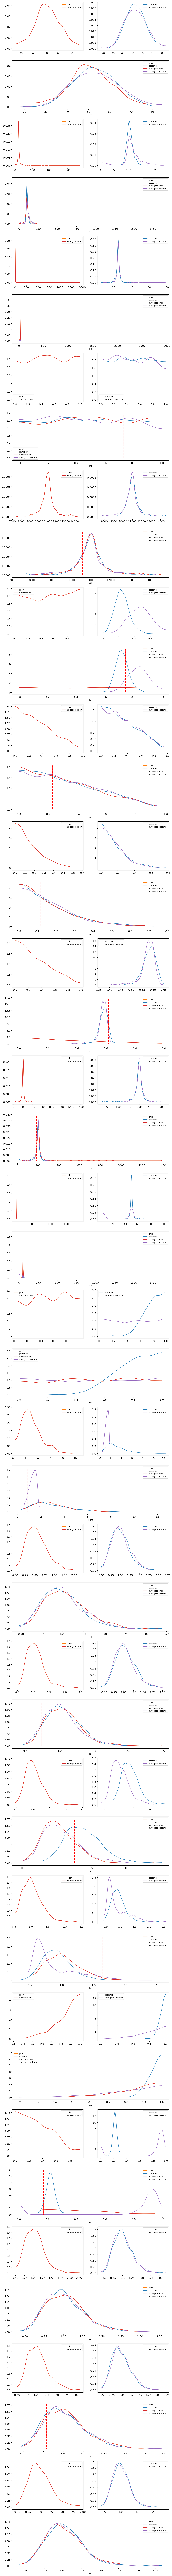

In [41]:
az.rcParams["plot.max_subplots"] = 200
keys = list(pyro_data.prior.data_vars.keys())
axs = az.plot_dist_comparison(pyro_data)
axs = az.plot_dist_comparison(
    pyro_data_surrogate,
    ax=axs
)
for i in range(axs.shape[0]):
    axs[i, 2].vlines(
        true_values[keys[i]][0],
        0,
        axs[i, 2].get_ylim()[1],
        color = 'red',
        linestyle = 'dashed'
    )
    s_prior_lines = [axs[i, 0].get_lines()[1], axs[i, 2].get_lines()[2]]
    s_posterior_lines = [axs[i, 1].get_lines()[1], axs[i, 2].get_lines()[3]]
    for s_prior_line in s_prior_lines:
        s_prior_line.set_color('C3')
        s_prior_line.set_label('surrogate prior')
    for s_posterior_line in s_posterior_lines:
        s_posterior_line.set_color('C4')
        s_posterior_line.set_label('surrogate posterior')
    
    for j in range(3):
        axs[i, j].legend()

In [66]:
def get_curves(params, eirs, etas):
    return vmap(
        vmap(
            full_solution,
            in_axes=[
                {k: 0 for k in params.keys()},
                None,
                None
            ]
        ),
        in_axes=[None, 0, 0]
    )(params, eirs, etas)

In [73]:
posterior_curves_surrogate = get_curves(posterior_samples_surrogate, EIRs, etas)
posterior_curves = get_curves(posterior_samples, EIRs, etas)
prior_curves = get_curves(prior, EIRs, etas)
true_curves = get_curves(without_obs(true_values), EIRs, etas)

Text(0.5, 1, 'Surrogate posterior immunity probability function')

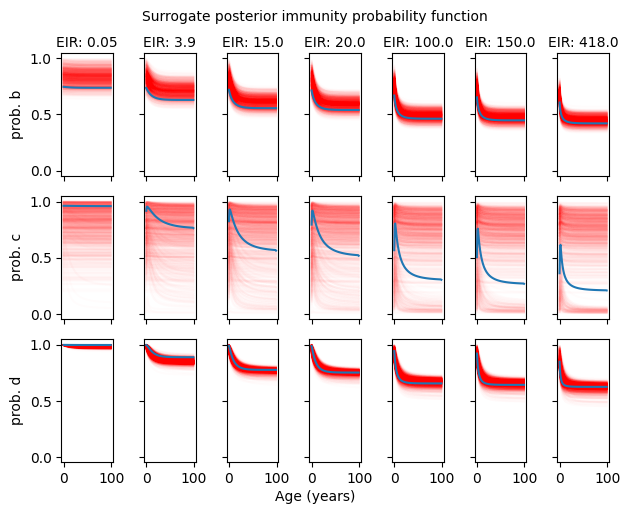

In [75]:
fig, axs = plt.subplots(3, len(EIRs), sharey=True, sharex=True)
imm_labels = ['b', 'c', 'd']
for i in range(len(EIRs)):
    axs[0, i].set_xlabel(
        f'EIR: {EIRs[i]}'
    )
    axs[0, i].xaxis.set_label_position('top')
    for imm in range(3):
        axs[imm, i].plot(posterior_curves_surrogate[i, :, 2+imm, :].T, color='r', alpha=.01)
        axs[imm, i].plot(true_curves[i, 0, 2+imm, :])
        axs[imm, 0].set_ylabel(f'prob. {imm_labels[imm]}')
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Surrogate posterior immunity probability function', ha='center')

Text(0.5, 1, 'Posterior immunity probability function')

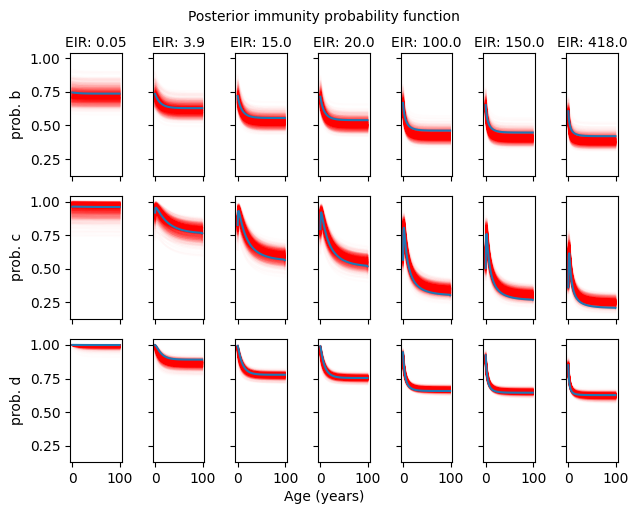

In [76]:
fig, axs = plt.subplots(3, len(EIRs), sharey=True, sharex=True)
imm_labels = ['b', 'c', 'd']
for i in range(len(EIRs)):
    axs[0, i].set_xlabel(
        f'EIR: {EIRs[i]}'
    )
    axs[0, i].xaxis.set_label_position('top')
    for imm in range(3):
        axs[imm, i].plot(posterior_curves[i, :, 2+imm, :].T, color='r', alpha=.01)
        axs[imm, i].plot(true_curves[i, 0, 2+imm, :])
        axs[imm, 0].set_ylabel(f'prob. {imm_labels[imm]}')
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Posterior immunity probability function', ha='center')

Text(0.5, 1, 'Surrogate posterior pos_M/inc function')

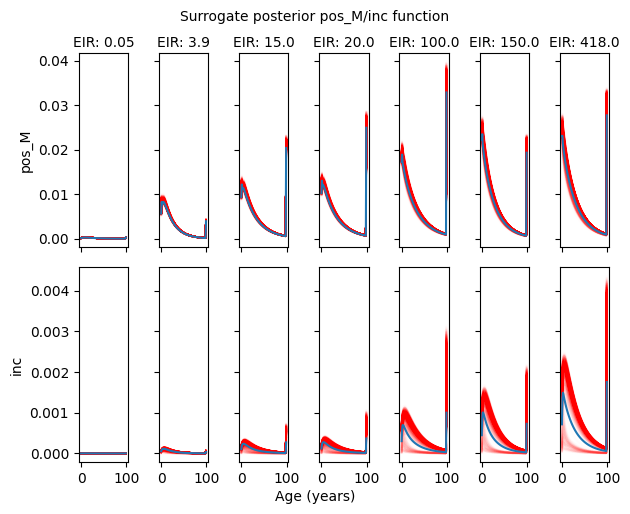

In [77]:
fig, axs = plt.subplots(2, len(EIRs), sharey='row', sharex=True)

prev_labels = ['pos_M', 'inc']
for i in range(len(EIRs)):
    for prev in range(2):
        axs[0, i].set_xlabel(f'EIR: {EIRs[i]}')
        axs[0, i].xaxis.set_label_position('top')
        axs[prev, i].plot(posterior_curves_surrogate[i, :, prev, :].T, color='r', alpha=.01)
        axs[prev, i].plot(true_curves[i, 0, prev, :])
        axs[prev, 0].set_ylabel(prev_labels[prev])
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Surrogate posterior pos_M/inc function', ha='center')

Text(0.5, 1, 'Posterior pos_M/inc function')

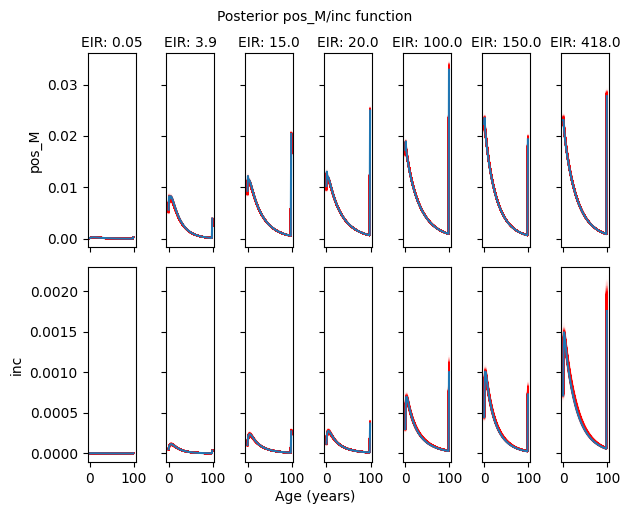

In [78]:
fig, axs = plt.subplots(2, len(EIRs), sharey='row', sharex=True)

prev_labels = ['pos_M', 'inc']
for i in range(len(EIRs)):
    for prev in range(2):
        axs[0, i].set_xlabel(f'EIR: {EIRs[i]}')
        axs[0, i].xaxis.set_label_position('top')
        axs[prev, i].plot(posterior_curves[i, :, prev, :].T, color='r', alpha=.01)
        axs[prev, i].plot(true_curves[i, 0, prev, :])
        axs[prev, 0].set_ylabel(prev_labels[prev])
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Posterior pos_M/inc function', ha='center')

Text(0.5, 1, 'Prior immunity probability function')

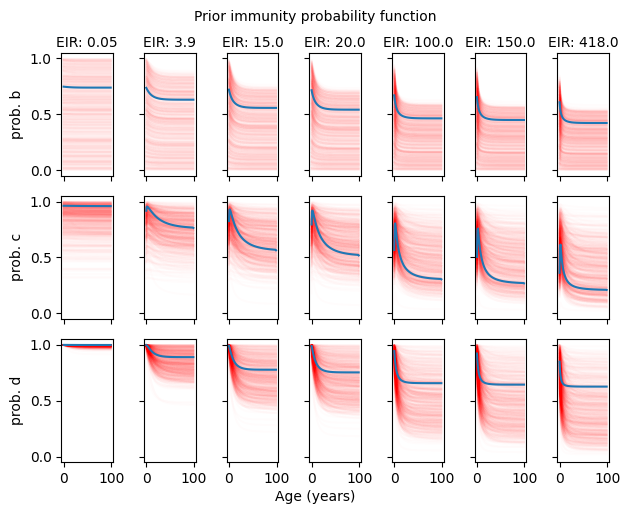

In [80]:
fig, axs = plt.subplots(3, len(EIRs), sharey=True, sharex=True)
imm_labels = ['b', 'c', 'd']
for i in range(len(EIRs)):
    axs[0, i].set_xlabel(
        f'EIR: {EIRs[i]}'
    )
    axs[0, i].xaxis.set_label_position('top')
    for imm in range(3):
        axs[imm, i].plot(prior_curves[i, :, 2+imm, :].T, color='r', alpha=.01)
        axs[imm, i].plot(true_curves[i, 0, 2+imm, :])
        axs[imm, 0].set_ylabel(f'prob. {imm_labels[imm]}')
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Prior immunity probability function', ha='center')

Text(0.5, 1, 'Prior pos_M/inc function')

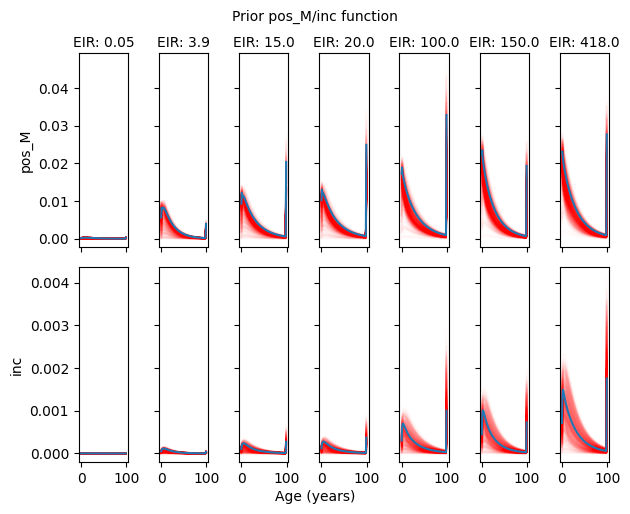

In [79]:
fig, axs = plt.subplots(2, len(EIRs), sharey='row', sharex=True)

prev_labels = ['pos_M', 'inc']
for i in range(len(EIRs)):
    for prev in range(2):
        axs[0, i].set_xlabel(
            f'EIR: {EIRs[i]}',
        )
        axs[0, i].xaxis.set_label_position('top')
        axs[prev, i].plot(prior_curves[i, :, prev, :].T, color='r', alpha=.01)
        axs[prev, i].plot(true_curves[i, 0, prev, :])
        axs[prev, 0].set_ylabel(prev_labels[prev])
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Prior pos_M/inc function', ha='center')

In [93]:
posterior_predictive_surrogate_s = Predictive(
    model,
    posterior_samples_surrogate
)(key, obs_prev, obs_inc, surrogate_impl)

posterior_predictive_s = Predictive(
    model,
    posterior_samples
)(key, obs_prev, obs_inc, surrogate_impl)

In [95]:
p_s_p = jnp.concatenate([
    posterior_predictive_surrogate['obs_prev'],
    posterior_predictive_surrogate['obs_inc']
], axis=3)
p_s_p_s = jnp.concatenate([
    posterior_predictive_surrogate_s['obs_prev'],
    posterior_predictive_surrogate_s['obs_inc']
], axis=3)
pp = jnp.concatenate([
    posterior_predictive['obs_prev'],
    posterior_predictive['obs_inc']
], axis=3)
pp_s = jnp.concatenate([
    posterior_predictive_s['obs_prev'],
    posterior_predictive_s['obs_inc']
], axis=3)

In [96]:
jnp.mean(pp - pp_s, axis=0)

Array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]], dtype=float64)

In [97]:
jnp.mean(p_s_p - p_s_p_s, axis=0)

Array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]], dtype=float64)